# NYC Taxi Trip Duration

## Loading Training Data

### import libraries

In [14]:
%matplotlib inline
import numpy as np
from numpy import random, float

import pandas as pd
from pandas import DataFrame
#from pandas.core import datetools
from pandas.lib import Timestamp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.metrics import accuracy_score, mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor

import time
import seaborn as sns #To conduct visual analysis
import statsmodels.api as sm
import math

import matplotlib.pyplot as plt
from ggplot import *
from geopy.distance import vincenty #for calculating Distance


### Read data from files.

In [15]:
pd.options.display.float_format = '{:,.15f}'.format

#input_file = "e:/sundog-consult/udemy/datascience/PastHires.csv"
train_file = "train.csv"
weather_file = "Weather_NYC_Data.csv"
result_file = "result.csv"


df = pd.read_csv(train_file, header = 0)
df_w = pd.read_csv(weather_file, header = 0)

df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,N,435


### Converting Datetime values from Object to Datetime

In [16]:
def min_bucket_func(row):    
    if row >= 0 and row < 300*24 :
        return math.floor((row/60)/5)
    else:
        return 200

df['within_min_range']=df['trip_duration'].apply(lambda x: min_bucket_func(x))

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df_w['Date'] = pd.to_datetime(df_w['Date'])

d={'Y':1 , 'N':0}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(d)
df['total_distance'] = df.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'],   x['dropoff_latitude'])).feet, axis=1).astype(int)


print("The deed is done")
df.head()

The deed is done


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,within_min_range,total_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,455,1,6421
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,0,663,2,7021
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,0,2124,7,11062
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,0,429,1,1566
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,0,435,1,1082


In [17]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,within_min_range,total_distance
count,"1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000"
mean,1.534950268879864,1.664529521939555,-73.973486304892816,40.750920908391734,-73.973415946945806,40.751799514900199,0.005515396491536,959.492272960365881,2.591597401422143,"9,471.005508540809387"
std,0.498777153905215,1.314242167812239,0.070901858422697,0.032881186257634,0.070643268097204,0.035890555605635,0.074060655231112,"5,237.431724497701907",8.070231295180847,"14,605.778452631819164"
min,1.000000000000000,0.000000000000000,-121.933341979980483,34.359695434570305,-121.933303833007798,32.181140899658203,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000
25%,1.000000000000000,1.000000000000000,-73.991867065429702,40.737346649169922,-73.991325378417969,40.735884666442871,0.000000000000000,397.000000000000000,1.000000000000000,"2,791.000000000000000"
50%,2.000000000000000,1.000000000000000,-73.981742858886719,40.754100799560547,-73.979751586914062,40.754524230957031,0.000000000000000,662.000000000000000,2.000000000000000,"5,042.000000000000000"
75%,2.000000000000000,2.000000000000000,-73.967330932617188,40.768360137939453,-73.963012695312500,40.769809722900391,0.000000000000000,"1,075.000000000000000",3.000000000000000,"9,374.000000000000000"
max,2.000000000000000,9.000000000000000,-61.335529327392578,51.881084442138672,-61.335529327392578,43.921028137207031,1.000000000000000,"3,526,282.000000000000000",200.000000000000000,"2,805,954.000000000000000"


### Make a separate column for Month and Date

In [18]:
df['Date']=df['pickup_datetime'].dt.year.map(str)+'-'+df['pickup_datetime'].dt.month.map(str)+'-'+df['pickup_datetime'].dt.day.map(str)
df['Date']=pd.to_datetime(df['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])

df_w.head()
#print("The deed is done")

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


### Let's join weather data:

In [19]:
df_join=df[df['within_min_range']<130].merge(df_w, on='Date', how='inner')

print("The deed is done")
df_join.head()

The deed is done


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090026855469,40.758766174316406,-73.953201293945312,40.765068054199219,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994483947753906,40.745086669921882,-73.998992919921875,40.722709655761719,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944358825683580,40.714488983154297,-73.910530090332031,40.709491729736328,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952880859375000,40.766468048095696,-73.978630065917969,40.761920928955078,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000


## Data Analysis

### Check which columns are numeric in data

### Data types:

In [20]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
dtype: object

In [21]:
df_join.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

### Finding missing values:

In [22]:
df.count() 

id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
within_min_range      1458644
total_distance        1458644
Date                  1458644
dtype: int64

So we have do not have any missing data in this data set.

### Data range for data

In [23]:
print("pickup_datetime min is " + str(df['pickup_datetime'].min()) + " and max is " + str(df['pickup_datetime'].max()))
print("dropoff_datetime min is " + str(df['dropoff_datetime'].min()) + " and max is " + str(df['dropoff_datetime'].max()))
print("trip_duration min is " + str(df['trip_duration'].min()) + " and max is " + str(df['trip_duration'].max()))
#print df.loc[[978383]]


pickup_datetime min is 2016-01-01 00:00:17 and max is 2016-06-30 23:59:39
dropoff_datetime min is 2016-01-01 00:03:31 and max is 2016-07-01 23:02:03
trip_duration min is 1 and max is 3526282


### Let's see if we have uniqueness in data

In [24]:
df.apply(pd.Series.nunique)



id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
within_min_range           25
total_distance          72615
Date                      182
dtype: int64

### Strip Off Non Numeric Columns

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nonnumeric_cols=df_join.select_dtypes(exclude=numerics).columns.values
print("Non numeric columns to look out for: " + str(nonnumeric_cols))

Non numeric columns to look out for: ['id' 'pickup_datetime' 'dropoff_datetime' 'Date' 'Events']


### Do we need these? Let's say no for now

In [20]:
#df_join = df_join.drop(['id','pickup_datetime','dropoff_datetime','Events'],axis=1)
print("Non-numeric columns dropped")


Non-numeric columns dropped


In [31]:
df_join.dtypes
#df_join["id"]

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

### Fixing missing values..

Let's see if we have any missing values anywhere

In [32]:
df_join.isnull().values.any()

False

### Free up Memory

In [23]:
#Release memory
del df
#del df_join

# Visualization:

Let us see now if there is any relationship between average monthly temperature versus trip duration and total_distance

In [33]:
#Aggregation and Joins:
df_bar = df_join.groupby('tempavg', as_index=False)['trip_duration','total_distance'].mean()

df_bar_count21 = df_join.groupby(['tempavg','Date'], as_index=False)['id'].count()
df_bar_count = df_bar_count21.groupby(['tempavg'], as_index=False)['id'].sum()
df_bar_join=df_bar.merge(df_bar_count, on='tempavg', how='inner')


Correlation between average daily temperature and total trip duration covered is: 0.645687235493
Correlation between average daily temperature and total distance covered is: 0.488147161639
Correlation between average daily temperature and total rides is: 0.0702330533882


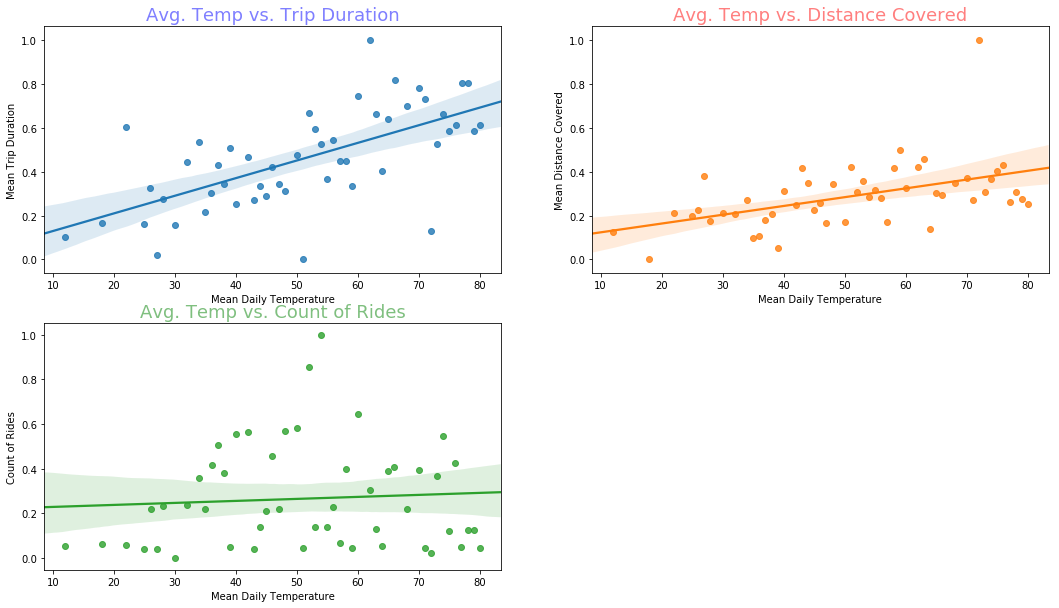

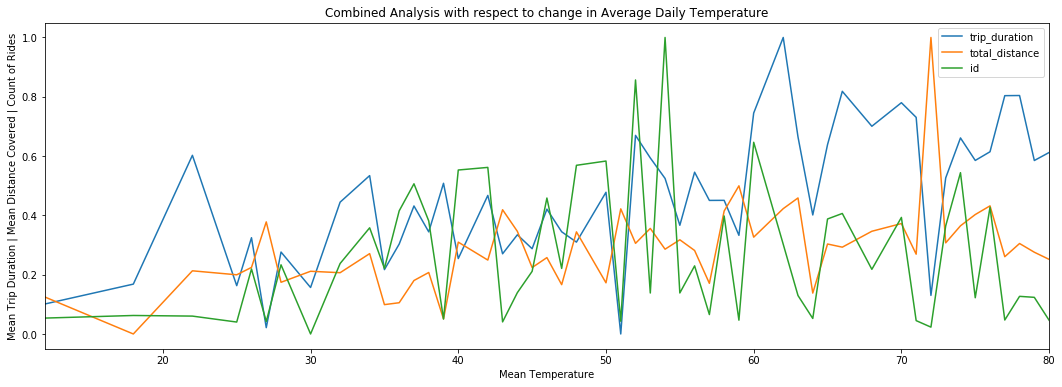

In [34]:
#Scaling:
features_to_scale = ['trip_duration','total_distance','id']
df_bar_join[features_to_scale] -= df_bar_join[features_to_scale].min()  # equivalent to df = df - df.min()
df_bar_join[features_to_scale] /= df_bar_join[features_to_scale].max() 

#Plotting:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar_join,fit_reg=True, ax=ax1)
sns.regplot(x='tempavg',y='total_distance',data=df_bar_join,fit_reg=True, ax=ax2)
sns.regplot(x='tempavg',y='id',data=df_bar_join,fit_reg=True, ax=ax3)

ax1.set(xlabel='Mean Daily Temperature', ylabel='Mean Trip Duration')
ax2.set(xlabel='Mean Daily Temperature', ylabel='Mean Distance Covered')
ax3.set(xlabel='Mean Daily Temperature', ylabel='Count of Rides')
ax1.set_title('Avg. Temp vs. Trip Duration', fontsize=18,color="b",alpha=0.5)
ax2.set_title('Avg. Temp vs. Distance Covered', fontsize=18,color="r",alpha=0.5)
ax3.set_title('Avg. Temp vs. Count of Rides', fontsize=18,color="g",alpha=0.5)

#Combined Graph:
ax = df_bar_join.plot(x='tempavg',figsize=(18, 6),title = 'Combined Analysis with respect to change in Average Daily Temperature')
ax.set_ylabel('Mean Trip Duration | Mean Distance Covered | Count of Rides')
ax.set_xlabel('Mean Temperature')

#Coorelation Analysis:
print('Correlation between average daily temperature and total trip duration covered is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['trip_duration'])))
print('Correlation between average daily temperature and total distance covered is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['total_distance'])))
print('Correlation between average daily temperature and total rides is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['id'])))


We can make three assumptions here:

When the average daily goes up, there is gradual increase in :

1- Total distance covered is slightly correlated to increase in temperature
2- Total trip Duration is relatively more correlated to increase in temperature
3- Temperature increase does not have any significant impact on total number of rides

Keeping in view point number 3, we can attribute total increase in duration and distance to increase in traffic. Causes for this increase are ambiguous at this point. Something to work on for future

Now, lets do some **Vendor Analysis**

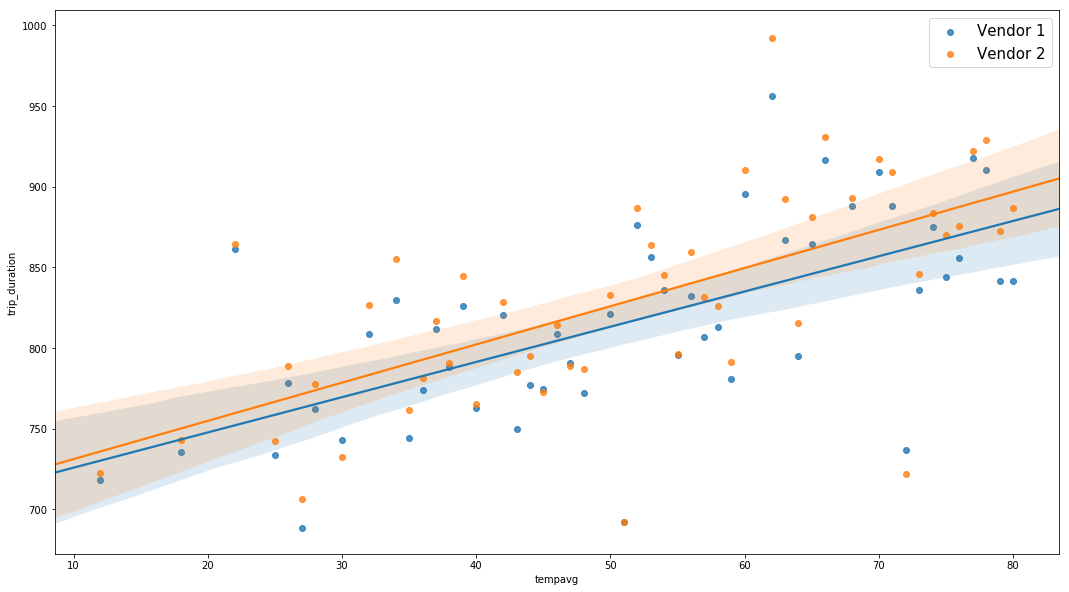

In [35]:
df_bar = df_join.groupby(['tempavg','vendor_id'], as_index=False)['trip_duration'].mean()

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==1],fit_reg=True, ax=ax1, label = 'Vendor 1')
sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==2],fit_reg=True, ax=ax1, label = 'Vendor 2')
ax1.legend(loc=1, prop={'size': 15})


Not much behavior difference between the two vendors with respect to temperature

# Train/Test split

In [36]:
np.random.seed()
msk = np.random.rand(len(df_join)) < 0.8
dfTrain = df_join[msk]
dfTest = df_join[~msk]

print(len(dfTrain))
print(len(dfTest))

1165014
291377


# Multi Variate Regression Analysis

Let's build and MVR

In [37]:
df_Train_features = pd.DataFrame(dfTrain.copy())
df_Train_features = df_Train_features.drop(['trip_duration','Date','within_min_range'],axis=1)
features = list(df_Train_features.columns[1:])
del df_Train_features
features

 

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'total_distance',
 'temphigh',
 'tempavg',
 'templow',
 'dewhigh',
 'dewavg',
 'dewlow',
 'humhigh',
 'humavg',
 'humlow',
 'seahigh',
 'seaavg',
 'sealow',
 'vishigh',
 'visavg',
 'vislow',
 'windhigh',
 'windavg',
 'preceiphigh',
 'precipsum',
 'Events',
 'Precip',
 'Snow']

Prepare for clustering the pickup coordinates:

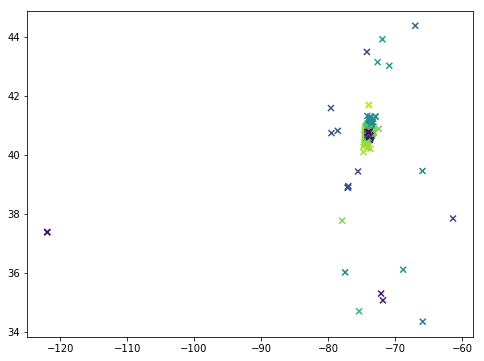

In [38]:
model = KMeans(n_clusters=50)
model = model.fit(scale(dfTrain[['pickup_longitude', 'pickup_latitude']]))
plt.figure(figsize=(8, 6))
plt.scatter(dfTrain['pickup_longitude'], dfTrain['pickup_latitude'], c=model.labels_.astype(float),marker='x')

Prepare for clustering the dropoff coordinates:

In [39]:
dfTrain.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

MVR starts here

In [40]:
features=['vendor_id','passenger_count','store_and_fwd_flag','total_distance','temphigh','tempavg','templow','dewhigh','dewavg','dewlow','humhigh','humavg','humlow','vishigh','visavg','vislow','windhigh','windavg','preceiphigh']
X = scale(dfTrain[features])
y = dfTrain['trip_duration']

clf = ExtraTreesRegressor()
est = clf.fit(X,y)

clf.score(scale(dfTest[features]),dfTest['trip_duration'])

#est.summary()

0.33505831101003536

# Test- Mania

In [44]:
test_file = "test.csv"
df_Test = pd.read_csv(test_file, header = 0)

df_Test['pickup_datetime'] = pd.to_datetime(df_Test['pickup_datetime'])
#df_Test['dropoff_datetime'] = pd.to_datetime(df_Test['dropoff_datetime'])
df_w['Date'] = pd.to_datetime(df_w['Date'])

d={'Y':1 , 'N':0}
df_Test['store_and_fwd_flag'] = df_Test['store_and_fwd_flag'].map(d)
df_Test['total_distance'] = df_Test.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'],   x['dropoff_latitude'])).feet, axis=1).astype(int)

df_Test['Date']=df_Test['pickup_datetime'].dt.year.map(str)+'-'+df_Test['pickup_datetime'].dt.month.map(str)+'-'+df_Test['pickup_datetime'].dt.day.map(str)
df_Test['Date']=pd.to_datetime(df_Test['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])


In [50]:

df_Test.dtypes
#df_Test.head()

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
total_distance                 int32
Date                  datetime64[ns]
dtype: object

In [48]:
df_w.head()

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


In [ ]:

df_join_Test=df_Test[df_Test['within_min_range']<130].merge(df_w, on='Date', how='inner')


df_join_Test.head()
df_join_Test = df_join_Test.drop(['id','pickup_datetime','Events'],axis=1)
print("The deed is done")

clf.score(scale(df_join_Test[features]),df_join_Test['trip_duration'])

## Using Random forests

We'll use a random forest of 10 decision trees to predict employment of specific candidate profiles:

In [265]:
from sklearn.feature_selection import RFE

clf = RandomForestClassifier(n_estimators=100) #means make 1000 random forests
clf = clf.fit(X, y)

#dfTest.head()

#dtTrainResults_RF=DataFrame(clf.predict(dfTrain[features]),columns=list([['Survived']]))
dtTestResults_RF=DataFrame(clf.predict(dfTest[features]),columns=list([['Survived']]))

#accuracy_score(dfTrain['Survived'], dtTrainResults_RF['Survived'], sample_weight=None)
accuracy_score(dfTest['Survived'], dtTestResults_RF['Survived'], sample_weight=None)

#RFE#
#rfe = RFE(clf, 3)
#rfe.fit(X, y)
#dtTestResults_RF=DataFrame(clf.predict(dfTest[features]),columns=list([['Survived']]))
#print accuracy_score(dfTest['Survived'], dtTestResults_RF['Survived'], sample_weight=None)

0.81714285714285717

# Results/Testing

Now let's perform prediction on original Test dataset

In [266]:
#Now performing this on real test set
##################
# 1 #Loading file
##################
test_file = "E:/2- GoogleDrive (Total 15GB)/Interests/Machine Learning/Udemy - Data Science and Machine Learning with Python/DataScience/TitanicTest.csv"
dfTestFinal = pd.read_csv(test_file,header=0)

##################
# 2 #Rectifying missing values
##################
d = {'male': 1, 'female': 0}
dfTestFinal['Sex'] = dfTestFinal['Sex'].map(d)
d = {'S': 0, 'Q': 1 ,'C':2}
dfTestFinal['Embarked']=dfTestFinal['Embarked'].map(d)
missFix_Test=dfTestFinal[features]
fill_NaN_Test = Imputer(missing_values=np.nan, strategy='median', axis=1)
imputed_DF_Test = pd.DataFrame(fill_NaN_Test.fit_transform(missFix_Test))
imputed_DF_Test.columns = missFix_Test.columns
imputed_DF_Test.index = missFix_Test.index

##################
# 3 #Performing Prediction
##################
clf.predict(imputed_DF_Test[features])
dtTestResults_RF_Final=DataFrame(clf.predict(imputed_DF_Test[features]),columns=list([['Survived']]))

#RFE#
#rfe.predict(imputed_DF_Test[features])
#dtTestResults_RF_Final=DataFrame(rfe.predict(imputed_DF_Test[features]),columns=list([['Survived']]))

##################
# 4 #Exporting Results
##################
Results_Main = dfTestFinal.join(dtTestResults_RF_Final['Survived'])
results_file = "E:/2- GoogleDrive (Total 15GB)/Interests/Machine Learning/Udemy - Data Science and Machine Learning with Python/DataScience/TitanicResults.csv"
Results_Main.to_csv(results_file)


## Tree Graphical Representation

Display it. Note you need to have pyplot2 installed for this to work.

To read this decision tree, each condition branches left for "true" and right for "false". When you end up at a value, the value array represents how many samples exist in each target value. So value = [0. 5.] mean there are 0 "Not Survived" and 5 "Survived" by the time we get to that point. value = [3. 0.] means 3 Not Survived and 0 Survived.

In [417]:
#Added to fix "GraphViz's executables not found" issue
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [245]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO()  #To save tree in it in next step

tree.export_graphviz(
                    clf, #the fitted tree itself
                    out_file=dot_data,  #Save the output tree in this variable in dotted format
                    feature_names=features #Input features to the tree for them to be displayed in tree
                    )  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  #convert dotted format to visual graph
Image(graph.create_png())  #Convert 'graph' image above to png

NameError: name 'clf' is not defined

# ROUGH WORK!

**Following was just testing to use OLS for finding missing values**

In [289]:
#Age_NMiss = df[df.Age.notnull()] #This is data where we have Age
#Age_Miss = df[df.Age.isnull()] #This is data where we DO NOT have Age

#Age_NMiss_Train = Age_NMiss[80:]
#Age_NMiss_Test = Age_NMiss[:80]

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import itertools

scale = StandardScaler()

#Columns list to consider for X
potentialFeatures=np.array(['Survived','Pclass','SibSp','Parch','Sex']).tolist()

#Making Y
#y=Age_NMiss_Train['Age']
y=scale.fit_transform(Age_NMiss_Train['Age'].as_matrix())


#Setting temporary values
max_X = 0.0

for iteration in range(1,len(potentialFeatures)+1):
    for stuff in itertools.combinations(potentialFeatures, iteration):
        Age_features=np.array(stuff).tolist()
        #Making X
        X = Age_NMiss_Train[Age_features]
        X[Age_features] = scale.fit_transform(X[Age_features].as_matrix())
        #Making OLS Model
        est = sm.OLS(y, X).fit()
        #Get max
        if max_X < est.rsquared:
            max_X=est.rsquared
            best_Features=stuff
            print str(max_X) + " " + str(Age_features)

print "and the final is"
bestFeatureFinal=np.array(best_Features).tolist()
X = Age_NMiss_Train[bestFeatureFinal]
X[bestFeatureFinal] = scale.fit_transform(X[bestFeatureFinal].as_matrix())
est2 = sm.OLS(y, X).fit()
print str(est2.rsquared) + str(bestFeatureFinal)

#print est2.predict(scale.fit_transform(Age_NMiss_Test[bestFeatureFinal].as_matrix()),Age_NMiss_Test['Age'])
#y=scale.inverse_transform(est2.predict(Age_NMiss_Test[bestFeatureFinal]))
#print y


C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

0.0066135016075 ['Survived']
0.127541486462 ['Pclass']
0.183104766203 ['Survived', 'Pclass']
0.202298667301 ['Pclass', 'SibSp']
0.25493576747 ['Survived', 'Pclass', 'SibSp']
0.257893052876 ['Survived', 'Pclass', 'SibSp', 'Parch']
0.25789313005 ['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex']
and the final is
0.25789313005['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex']


C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
